# Word2Vec then RNN

## Imports and setting up TensorBoard

In [1]:
from data_preparation import *
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, TimeDistributed, Dropout, Embedding
from keras.optimizers import Adam
from keras_train_helper import tfauc, rotateTensorboardLogs, PrintAucCallback, plotLearningCurve
from keras.regularizers import L1L2
from tensorflow.python.client import device_lib
from keras.callbacks import TensorBoard

print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6368271362963190084
]


Using TensorFlow backend.


## Loading data and setting up preprocessing tools

In [2]:
train, test, allData, contestTest = loadData()

Loading datasets...
train: (127656, 8), test: (31915, 8), allData: (159571, 8), contestTest: (153164, 2)


### Split sentences and apply word correction & splitting

In [21]:
%%time
from sklearn.pipeline import Pipeline

maxSeqLength = 250

splitter = SentenceSplitter("comment_text")
stopwordsRemover = StopwordsRemover()
wordEmbedding = loadWordEmbedding("../../state/external-models/glove.6B/saved-50.bin")

allWords = splitter.transform(pd.concat([allData, contestTest]))
textWords = set([word for sentence in allWords for word in sentence])
# missingWords = textWords - set(list(wordEmbedding.vocab.keys()))

missingWordsResolutionDict = loadObject("./missingWordsResolution.plk")
missingWords = set(missingWordsResolutionDict.keys()) - set(list(wordEmbedding.vocab.keys()))
missingWordsResolver = MissingWordsResolver(missingWordsResolutionDict, missingWords)

splittingPipeline = Pipeline(steps=[
    ("split", splitter),
#     ("removeStopwords", stopwordsRemover),
    ("resolveMissingWords", missingWordsResolver) ])

Splitting sentences...
CPU times: user 11.8 s, sys: 320 ms, total: 12.1 s
Wall time: 12.1 s


### W2I and zero padding

In [22]:
%%time
resolvedWords = missingWordsResolver.transform(allWords)

w2i = Word2Int(resolvedWords)
zeroPadder = ZeroPadder(maxSeqLength)

indexingPipeline = Pipeline(steps=[
    ("w2i", w2i),
    ("zeroPadding", zeroPadder)
])

Resolving missing words...
Loading w2i and i2w dictionaries...
CPU times: user 8.96 s, sys: 48 ms, total: 9.01 s
Wall time: 9.01 s


In [23]:
preparationPipeline = Pipeline(steps=[
    ("splittingPipeline", splittingPipeline),
    ("indexingPipeline", indexingPipeline)
])

### W2V

In [33]:
%%time
w2v = Word2Vec(wordEmbedding, 50, w2i.i2w, seed=4324)

Loading word2vec dictionary...
CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 98.6 ms


In [34]:
embeddingMatrix, i2v = w2v.embeddingMatrix()

## Define the model

### Define the model

In [36]:
lstmUnits = 100
numClasses = 2
batchSize = 1024

def defineModel(dropout, recurrent_dropout):
    model = Sequential()

    model.add(Embedding(
        embeddingMatrix.shape[0],
        embeddingMatrix.shape[1],
        weights=[embeddingMatrix],
        input_length=maxSeqLength,
        trainable=False))

#     model.add(Bidirectional(LSTM(
#         lstmUnits, 
#         dropout=dropout, 
#         recurrent_dropout=recurrent_dropout, 
#         name="LSTM")))

    model.add(LSTM(
        lstmUnits, 
        dropout=dropout, 
        recurrent_dropout=recurrent_dropout, 
        name="LSTM"))

    model.add(Dense(
        2, 
        activation="softmax", 
        name="softmax_output"))
    
    model.compile(
        loss="categorical_crossentropy", 
        optimizer="nadam", 
        metrics=[tfauc])

    print(model.summary())
    return model

## Prepare data and train the model

In [39]:
def fitModel(model, trainDataset, testDataset, printAucCallback, label, epochs, fast=False):
    print("Training model for target variable: {}".format(label))
    
    tf.set_random_seed(43245)
    np.random.seed(453252)
    
    labelizer = Labelizer(label)
    oversampler = Oversampler(label)
    
    trainOversampled = oversampler.transform(trainDataset)

    trainSentences = preparationPipeline.transform(trainOversampled)
    trainLabels = labelizer.transform(trainOversampled)
    testSentences = preparationPipeline.transform(testDataset)
    testLabels = labelizer.transform(testDataset)

    printAucCallback.setDatasets([trainSentences, trainLabels], [testSentences, testLabels])

    model.fit(
        trainSentences, 
        trainLabels, 
        nb_epoch=epochs, 
        batch_size=batchSize,
        callbacks=[] if fast else [printAucCallback])
    
    return model, testSentences, testLabels

In [45]:
%%time
dropout = 0.6
recurrentDropout = 0.2
model = defineModel(dropout, recurrentDropout)
printAucCallback = PrintAucCallback(8192, printFrequency=0.02)

model, testSentences, testLabels = fitModel(model, train[:20000], test[:20000], printAucCallback, "toxic", 2)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


## Query cell state and cell output

In [41]:
from keras.layers import Input
from keras.models import Model

In [61]:
inputLayer = Input(shape=(maxSeqLength,))

embeddingLayer = Embedding(
    embeddingMatrix.shape[0],
    embeddingMatrix.shape[1],
    weights=[embeddingMatrix],
    input_length=maxSeqLength,
    trainable=False)(inputLayer)

lstmOutput, _, stateC = LSTM(
        lstmUnits, 
        dropout=dropout, 
        recurrent_dropout=recurrentDropout, 
        weights=model.layers[1].get_weights(),
        return_state=True,
        name="LSTM_get_outputs")(embeddingLayer)

outputModel = Model(inputs=inputLayer, outputs=lstmOutput)
cellStateModel = Model(inputs=inputLayer, outputs=stateC)

In [62]:
def outputs(sentence):
    preparedSentence = preparationPipeline.transform(pd.DataFrame([sentence], columns=["comment_text"]))
    return [modelX.predict(preparedSentence) for modelX in [outputModel, cellStateModel]]

## Plot network

In [413]:
outputPredictions = outputModel.predict(testSentences)
cellStatePredictions = cellStateModel.predict(testSentences)

def normalizeVector(v, minimum, maximum):
    return (v - minimum) / (maximum - minimum)

def normalizeOutput(v):
    return normalizeVector(v, outputPredictions.min(), outputPredictions.max())

def normalizeCellState(v):
    return normalizeVector(v, cellStatePredictions.min(), cellStatePredictions.max())

In [432]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib.pyplot import text

def plotActivations(sentence):
    outputActivations, cellStateActivations = outputs(sentence)
    
    plt.clf()
    plt.figure(figsize=(20, 5))

    cellStates =[Rectangle(
            (i / lstmUnits, 0.4), 
            1 / lstmUnits, 
            0.2, 
            alpha=a, 
            color="navy") 
         for (i, a) in zip(range(lstmUnits), normalizeCellState(cellStateActivations[0]))]

    cellOutputs =[Rectangle(
            (i / lstmUnits, 0.6), 
            1 / lstmUnits, 
            0.2, 
            alpha=a, 
            color="navy") 
         for (i, a) in zip(range(lstmUnits), normalizeOutput(outputActivations[0]))]

    words = splitter.transform(pd.DataFrame([sentence], columns=["comment_text"]))[0]
    for (i, word) in zip(range(len(words)), words):
        text(i/lstmUnits, 0.3, word, fontsize=10, rotation="vertical", ha="left", va="center")

    ax = plt.gca()
    ax.set_axis_off()
    for state in cellStates:
        ax.add_patch(state)

    for output in cellOutputs:
        ax.add_patch(output)
    plt.show()

Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...


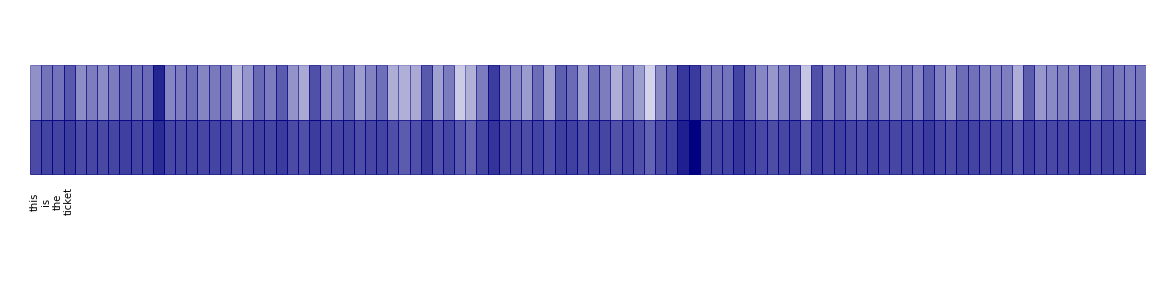

In [442]:
plotActivations("This is the ticket!")

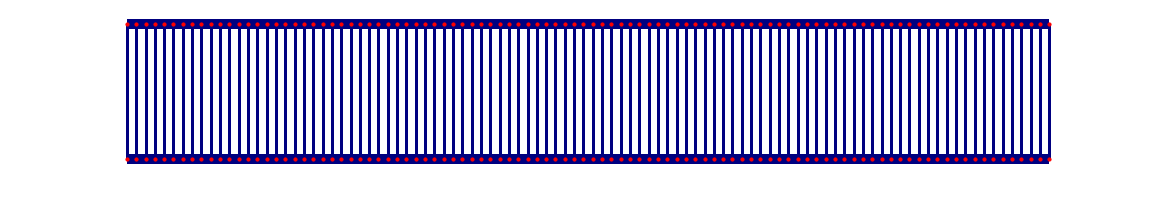

hello


In [372]:
import networkx as nx


numberOfNeurons = 100

wordsLayer = list(zip(range(numberOfNeurons), range(1, numberOfNeurons)))
rnnLayer = list(zip(range(numberOfNeurons, 2*numberOfNeurons), range(numberOfNeurons + 1, 2*numberOfNeurons)))
layersConnection = list(zip(range(numberOfNeurons), range(numberOfNeurons, 2*numberOfNeurons)))
plt.figure(figsize=(20, 3))

pos = dict(list({x: [2*x, 0] for x in range(numberOfNeurons)}.items())
           + list({x: [2*(x - numberOfNeurons), 1] for x in range(numberOfNeurons, 2*numberOfNeurons)}.items()))

G = nx.Graph()

# G.add_edges_from(wordsLayer + rnnLayer + layersConnection)

# nx.draw(graph, node_color="blue")

# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, 
    nodelist=list(range(numberOfNeurons)) + list(range(numberOfNeurons, 2*numberOfNeurons)), 
    cmap=plt.get_cmap('jet'), node_size = 10)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edgelist=layersConnection, edge_color='navy', arrows=True, width=3)
nx.draw_networkx_edges(G, pos, edgelist=wordsLayer+rnnLayer, edge_color='navy', arrows=True, width=10)

ax = plt.gca()
ax.set_axis_off()
plt.show()
print("hello")

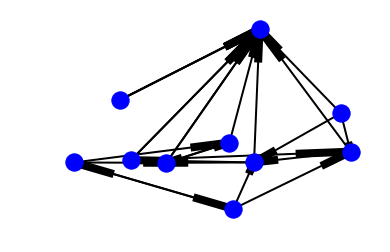

In [99]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.generators.directed.random_k_out_graph(10, 3, 0.5)
pos = nx.layout.spring_layout(G)

M = G.number_of_edges()
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]

nodes = nx.draw_networkx_nodes(G, pos, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10, edge_cmap=plt.cm.Blues, width=2)
# # set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [70]:
import matplotlib.pyplot as plt

def analyze(sent):
    plt.plot(outputs(sent)[1][0])

Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...
Splitting sentences...
Resolving missing words...
Converting words to integers...
Zero-padding...


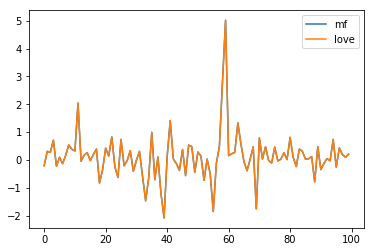

In [76]:
plt.clf()
analyze("fuck you motherfucker dick in your ass fuck your mother pussy deep inside cum on your tits")
analyze("love is a to picnics every day")

plt.legend(["mf", "love"])
plt.show()

## Compare train and test data

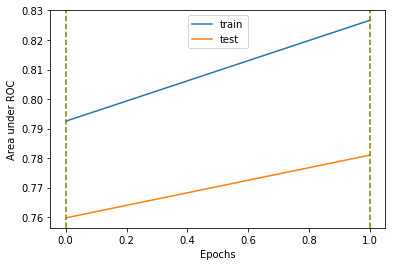

In [13]:
plotLearningCurve(printAucCallback.listOfAucsTrain, printAucCallback.listOfAucsTest)

           P Neutral  P Toxic
T Neutral        766    17282
T Toxic           39     1913


           P Neutral  P Toxic
T Neutral    0.03830  0.86410
T Toxic      0.00195  0.09565


0.181


0.7432


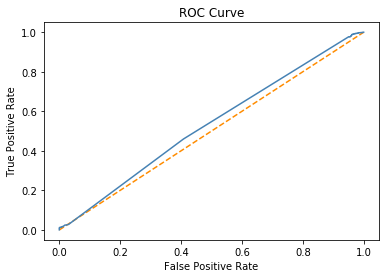

In [398]:
%%time
from evaluate_predictions import evaluatePredictions

predictions = model.predict(testSentences, batch_size=4*batchSize)
binaryPredictions = np.where(predictions[:, 1] > 0.5, 1, 0)
labels = testLabels[:, 1]

evaluatePredictions(pd.Series(labels), binaryPredictions, predictions)

## Run on all data and export submission

In [ ]:
%%time
contestModels = [
    fitModel(defineModel(dropout, recurrent_dropout), allData, test, PrintAucCallback(8192, printFrequency=0.02), label, epochs, fast=True)
    for (label, epochs, dropout, recurrent_dropout)
    in [("toxic", 6, 0.7, 0.2), 
        ("severe_toxic", 7, 0.9, 0.2), 
        ("obscene", 7, 0.7, 0.2), 
        ("threat", 7, 0.9, 0.3), 
        ("insult", 6, 0.7, 0.2), 
        ("identity_hate", 6, 0.8, 0.2)]]

In [ ]:
%%time
categories = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
contestPredictionProbabilities = {
    category: model[0].predict(preparationPipeline.transform(contestTest), batch_size=8192) 
    for (category, model) in zip(categories, contestModels)}

In [33]:
suffledResult = pd.DataFrame(dict(
    [("id", contestTest.id)] 
    + [(name, preds[:, 1]) for (name, preds) in contestPredictionProbabilities.items()]))

result = suffledResult[["id"] + categories]

In [34]:
result.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.107428,0.086610,0.179781,0.043975,0.104099,0.086608
1,0000247867823ef7,0.147077,0.124943,0.256728,0.045869,0.097912,0.125053
2,00013b17ad220c46,0.144134,0.122432,0.231361,0.073960,0.156137,0.122611
3,00017563c3f7919a,0.094946,0.076373,0.186833,0.022637,0.050725,0.076566
4,00017695ad8997eb,0.105768,0.083794,0.182512,0.037039,0.066183,0.083650


In [ ]:
result.shape

In [45]:
result.to_csv("./submissions/w2v-then-rnn-increased-dropout.csv", index=False)